Лабораторная работа №6
Выполнил студент гр. КИ21-17/1б Самарин Никита

### Задачи:
Решить задачу о многоруком бандите. Для решения использовать алгоритмы EpsGreedy, Softmax и UCB1.
Подобрать параметры.
Построить графики среднего выигрыша.

In [57]:
import matplotlib.pyplot as plt
import numpy as np

In [58]:
class Environment():
    def __init__(self, probs, reward):
        self.probs = probs
        self.reward = reward
        self._optimal_action = np.argmax(list(map(lambda x,y: x*y, probs, reward)))
        self._optimal_reward = np.max(list(map(lambda x,y: x*y, probs, reward)))

    def step(self, action):
        return self.reward[action] if np.random.rand(1).item() < self.probs[action] else 0

env = Environment([0.3, 0.2, 0.1, 0.2, 0.7], [1, 1, 2, 1, 3])

In [59]:
from abc import ABC, abstractmethod

class BaseStrategy(ABC):
    def __init__(self, n_arms, param):
        self.avg = np.zeros(n_arms)
        self.n = [0 for _ in range(n_arms)]
        self.param = param
        self.n_arms = n_arms

    @abstractmethod
    def make_action(self):
        pass

    def update(self, action, reward):
        self.n[action] += 1
        self.avg[action] = (self.avg[action] * (self.n[action]-1) + reward)/self.n[action]

    def reset(self):
        self.__init__(self.n_arms, self.param)

class EGreedy(BaseStrategy):

    def make_action(self):
        if np.random.random() > self.param:
            return np.argmax(self.avg)
        return np.random.randint(self.n_arms)

class SoftMax(BaseStrategy):
    def make_action(self):
        x = self.avg/self.param
        probs = np.exp(x)/np.sum(np.exp(x))
        return np.random.choice(self.n_arms, p=probs)

class UCB1(BaseStrategy):

    def make_action(self):
        c = np.sqrt(self.param * np.log(np.sum(self.n)+1)/(np.array(self.n)+1))
        upper_bounds = self.avg + c
        return np.argmax(upper_bounds)

In [60]:
def run_n_iterations(env, strategy, n_iters):
    w_opt_stat, r_avg_stat, r_total_stat, reg_stat = [],[],[],[]
    w_opt_times, total_reward, reg = 0, 0, 0
    for episode in range(1, n_iters+1):
        action = strategy.make_action()
        reward = env.step(action)
        strategy.update(action, reward)
        w_opt_stat.append(1 if action==env._optimal_action else 0)
        total_reward += reward
        r_total_stat.append(total_reward)
        r_avg_stat.append(total_reward/episode)
        reg += env._optimal_reward - reward
        reg_stat.append(reg)
    return w_opt_stat, r_avg_stat, r_total_stat, reg_stat

def run_n_times(n_repeat, env, n_iters, strategy):
    w_opt_stat_full, r_avg_stat_full = [],[]
    r_total_stat_full, reg_stat_full = [],[]
    for _ in range(n_repeat):
        strategy.reset()
        w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_iterations(env,
                                                                        strategy,
                                                                        n_iters)
        w_opt_stat_full.append(w_opt_stat)
        r_avg_stat_full.append(r_avg_stat)
        r_total_stat_full.append(r_total_stat)
        reg_stat_full.append(reg_stat)
    return np.array(w_opt_stat_full).mean(axis=0), np.array(r_avg_stat_full).mean(axis=0),\
       np.array(r_total_stat_full).mean(axis=0), np.array(reg_stat_full).mean(axis=0)

def plot_stats(w_opt_stat, r_avg_stat, r_total_stat, reg_stat, legends = False):
    plt.figure(figsize=(12, 7))
    plt.subplot(2, 2, 1)
    for i in w_opt_stat:
        plt.plot(i)
    plt.xlabel('t')
    plt.ylabel('w_opt')
    if legends: plt.legend(legends)
    plt.subplot(2, 2, 2)
    for i in r_avg_stat:
        plt.plot(i)
    plt.xlabel('t')
    plt.ylabel('r_avg')
    if legends: plt.legend(legends)
    plt.subplot(2, 2, 3)
    for i in r_total_stat:
        plt.plot(i)
    plt.xlabel('t')
    plt.ylabel('r_total')
    if legends: plt.legend(legends)
    plt.subplot(2, 2, 4)
    for i in reg_stat:
        plt.plot(i)
    plt.xlabel('t')
    plt.ylabel('reg')
    if legends: plt.legend(legends)

## EGreedy

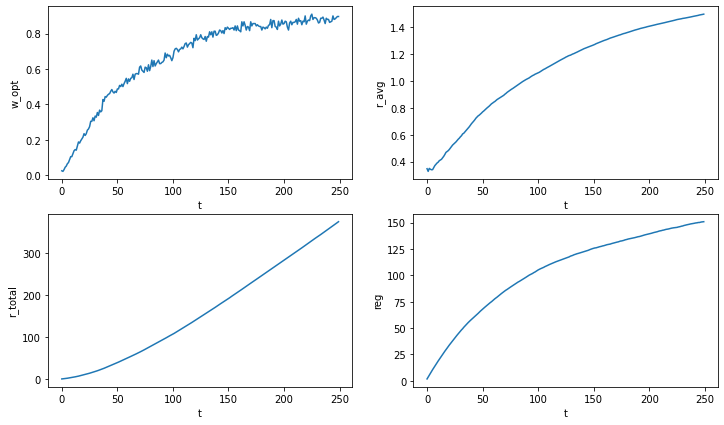

In [61]:
w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_times(300, env, 250, EGreedy(5, 0.1))
plot_stats([w_opt_stat], [r_avg_stat], [r_total_stat], [reg_stat])

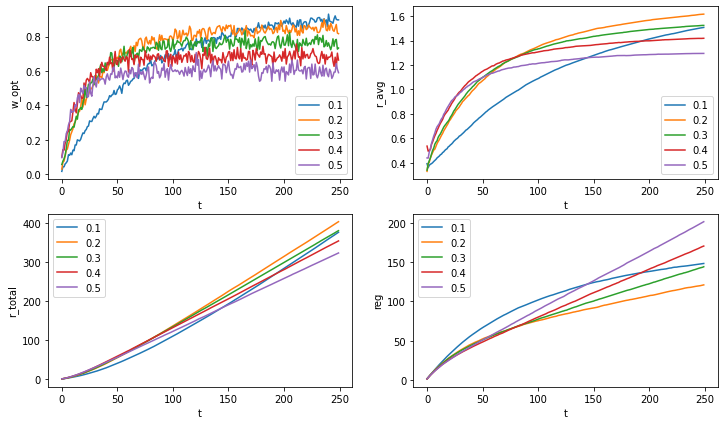

In [62]:
w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full = [],[],[],[]
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
for epsilon in epsilons:
  w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_times(300, env, 250, EGreedy(5, epsilon))
  for f, l in zip([w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full],
                  [w_opt_stat, r_avg_stat, r_total_stat, reg_stat]):
    f.append(l)
plot_stats(w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full, epsilons)

## SoftMax

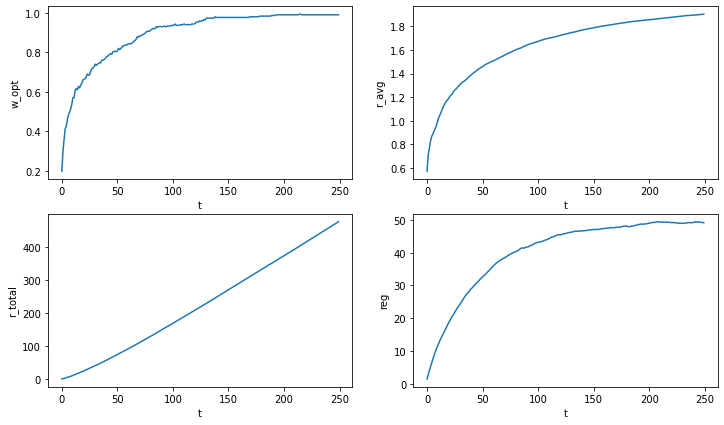

In [63]:
w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_times(300, env, 250, SoftMax(5, 0.1))
plot_stats([w_opt_stat], [r_avg_stat], [r_total_stat], [reg_stat])

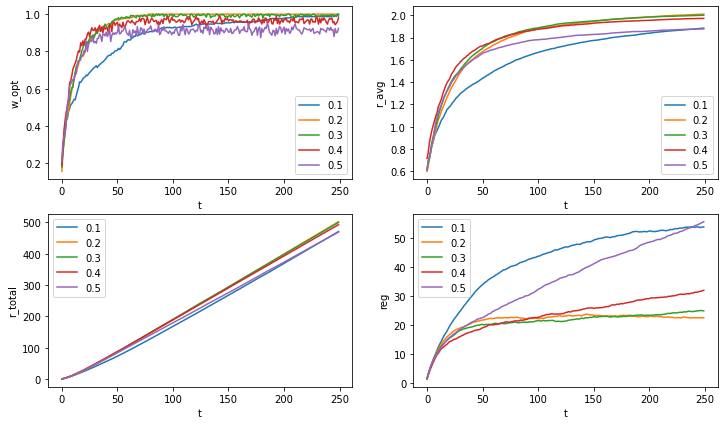

In [64]:
w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full = [],[],[],[]
thetas = [0.1, 0.2, 0.3, 0.4, 0.5]
for theta in thetas:
  w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_times(300, env, 250, SoftMax(5, theta))
  for f, l in zip([w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full],
                  [w_opt_stat, r_avg_stat, r_total_stat, reg_stat]):
    f.append(l)
plot_stats(w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full, thetas)

## UCB1

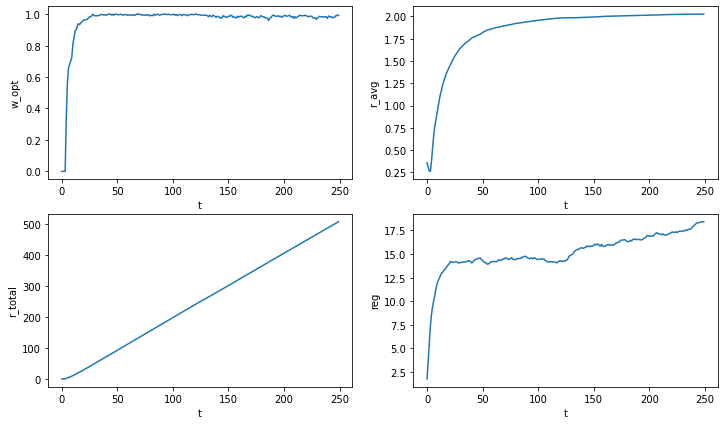

In [65]:
w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_times(300, env, 250, UCB1(5, 2))
plot_stats([w_opt_stat], [r_avg_stat], [r_total_stat], [reg_stat])

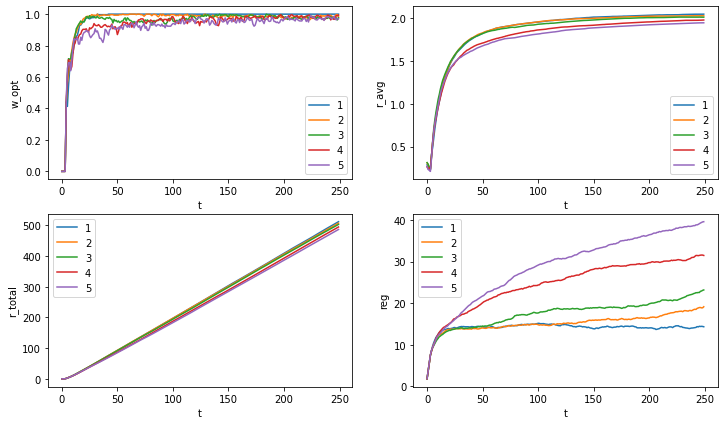

In [66]:
w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full = [],[],[],[]
params = [1, 2, 3, 4, 5]
for param in params:
    w_opt_stat, r_avg_stat, r_total_stat, reg_stat = run_n_times(300, env, 250, UCB1(5, param))
    for f, l in zip([w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full],
                  [w_opt_stat, r_avg_stat, r_total_stat, reg_stat]):
        f.append(l)
plot_stats(w_opt_stat_full, r_avg_stat_full, r_total_stat_full, reg_stat_full, params)